In [1]:
print("🔗 Connexion à Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive monté avec succès")

import os
from pathlib import Path

print("\n📁 Configuration des chemins de travail...")

# Chemins principaux
BASE_PATH = "/content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys"
DATA_PATH = f"{BASE_PATH}/data"
OUTPUTS_PATH = f"{BASE_PATH}/outputs"

🔗 Connexion à Google Drive...
Mounted at /content/drive
✅ Google Drive monté avec succès

📁 Configuration des chemins de travail...


# 🤝 Modèle Collaboratif avec LightFM


**Objectif :** Premier modèle de recommandation basé uniquement sur les interactions user-item
- Installation et configuration LightFM
- Entraînement modèle collaboratif
- Tests des loss functions (WARP, BPR, Logistic)
- Évaluation métriques de base

---

## 🔧 INSTALLATION ET IMPORTS


In [2]:
!pip install git+https://github.com/daviddavo/lightfm

  Cloning https://github.com/daviddavo/lightfm to /tmp/pip-req-build-try0853n
  Running command git clone --filter=blob:none --quiet https://github.com/daviddavo/lightfm /tmp/pip-req-build-try0853n
  Resolved https://github.com/daviddavo/lightfm to commit f0eb500ead54ab65eb8e1b3890337a7223a35114
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp312-cp312-linux_x86_64.whl size=1099142 sha256=2a53345dedf9b16ade13191018c250d6cc4104bbc5b91219ec44a9696e03546e
  Stored in directory: /tmp/pip-ephem-wheel-cache-orfzg1_y/wheels/fd/89/93/70c1e5f378ee5043de89387ee3ef6852ff39e3b9eb44ecc1a3
Successfully built lightfm


## 🔧 INSTALLATION ET IMPORTS


In [4]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.cross_validation import random_train_test_split
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✅ LightFM installé et importé")

✅ LightFM installé et importé


In [5]:

# Redéfinir IDMapper pour le déchargement pickle
class IDMapper:
    """Classe pour mapper IDs vers entiers et vice-versa"""

    def __init__(self, ids):
        self.id_to_idx = {id_val: idx for idx, id_val in enumerate(sorted(ids))}
        self.idx_to_id = {idx: id_val for id_val, idx in self.id_to_idx.items()}
        self.n_items = len(self.id_to_idx)

    def map_to_idx(self, ids):
        return [self.id_to_idx.get(id_val, -1) for id_val in ids]

    def map_to_id(self, indices):
        return [self.idx_to_id.get(idx, None) for idx in indices]

# Maintenant charger les données
with open(f"{OUTPUTS_PATH}/prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

## 📁 CHARGEMENT DONNÉES PRÉPARÉES

In [6]:
print("\n📊 Chargement des données préparées...")

with open(f"{OUTPUTS_PATH}/prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

train_matrix = data['matrices']['train']
test_matrix = data['matrices']['test']
user_mapper = data['mappings']['user_mapper']
item_mapper = data['mappings']['item_mapper']

print(f"✅ Train: {train_matrix.shape}, Test: {test_matrix.shape}")


📊 Chargement des données préparées...
✅ Train: (9848, 7837), Test: (9848, 7837)


## 🧪 TEST DES LOSS FUNCTIONS


In [7]:
print("\n" + "="*60)
print("🧪 COMPARAISON DES LOSS FUNCTIONS")
print("="*60)

# Configuration modèles
loss_functions = ['warp', 'bpr', 'logistic']
results = {}

for loss in loss_functions:
    print(f"\n⏳ Test {loss.upper()}...")

    # Entraînement
    model = LightFM(loss=loss, random_state=42, no_components=30)
    start_time = time.time()
    model.fit(train_matrix, epochs=10, num_threads=2, verbose=True)
    train_time = time.time() - start_time

    # Évaluation
    train_precision = precision_at_k(model, train_matrix, k=10).mean()
    test_precision = precision_at_k(model, test_matrix, k=10, train_interactions=train_matrix).mean()
    train_auc = auc_score(model, train_matrix).mean()
    test_auc = auc_score(model, test_matrix, train_interactions=train_matrix).mean()

    results[loss] = {
        'train_precision@10': train_precision,
        'test_precision@10': test_precision,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'train_time': train_time
    }

    print(f"  Precision@10: {test_precision:.4f}")
    print(f"  AUC: {test_auc:.4f}")
    print(f"  Temps: {train_time:.1f}s")

# Résultats comparatifs
comparison_df = pd.DataFrame(results).T
print(f"\n📊 COMPARAISON LOSS FUNCTIONS:")
print(comparison_df.round(4))

# Sélection meilleure loss
best_loss = comparison_df['test_precision@10'].idxmax()
print(f"\n🏆 Meilleure loss function: {best_loss.upper()}")


🧪 COMPARAISON DES LOSS FUNCTIONS

⏳ Test WARP...


Epoch: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


  Precision@10: 0.0004
  AUC: 0.1968
  Temps: 1.5s

⏳ Test BPR...


Epoch: 100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


  Precision@10: 0.0001
  AUC: 0.4819
  Temps: 1.2s

⏳ Test LOGISTIC...


Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.31it/s]


  Precision@10: 0.0006
  AUC: 0.1959
  Temps: 0.8s

📊 COMPARAISON LOSS FUNCTIONS:
          train_precision@10  test_precision@10  train_auc  test_auc  \
warp                  0.0513             0.0004     0.9317    0.1968   
bpr                   0.0004             0.0001     0.5116    0.4819   
logistic              0.0012             0.0006     0.8727    0.1959   

          train_time  
warp          1.5360  
bpr           1.2401  
logistic      0.8228  

🏆 Meilleure loss function: LOGISTIC


## 🎯 MODÈLE OPTIMAL

In [8]:
print("\n" + "="*60)
print("🎯 ENTRAÎNEMENT MODÈLE OPTIMAL")
print("="*60)

# Configuration optimale
optimal_model = LightFM(
    loss=best_loss,
    no_components=50,  # Plus de facteurs latents
    learning_rate=0.05,
    random_state=42
)

# Entraînement avec suivi
epochs = 20
train_precisions = []
test_precisions = []

print(f"🚂 Entraînement {epochs} epochs avec {best_loss}...")

for epoch in tqdm(range(epochs)):
    optimal_model.fit_partial(train_matrix, epochs=1)

    if epoch % 5 == 0:  # Évaluation tous les 5 epochs
        train_prec = precision_at_k(optimal_model, train_matrix, k=10).mean()
        test_prec = precision_at_k(optimal_model, test_matrix, k=10, train_interactions=train_matrix).mean()
        train_precisions.append(train_prec)
        test_precisions.append(test_prec)

print("✅ Entraînement terminé")


🎯 ENTRAÎNEMENT MODÈLE OPTIMAL
🚂 Entraînement 20 epochs avec logistic...


100%|██████████| 20/20 [03:31<00:00, 10.59s/it]

✅ Entraînement terminé


## 📊 ÉVALUATION COMPLÈTE


In [9]:
print("\n" + "="*60)
print("📊 ÉVALUATION COMPLÈTE DU MODÈLE")
print("="*60)

# Métriques multiples
def evaluate_model(model, train_interactions, test_interactions, k_values=[5, 10, 20]):
    metrics = {}

    for k in k_values:
        # Precision et Recall
        train_prec = precision_at_k(model, train_interactions, k=k).mean()
        test_prec = precision_at_k(model, test_interactions, k=k, train_interactions=train_interactions).mean()
        train_recall = recall_at_k(model, train_interactions, k=k).mean()
        test_recall = recall_at_k(model, test_interactions, k=k, train_interactions=train_interactions).mean()

        metrics[f'train_precision@{k}'] = train_prec
        metrics[f'test_precision@{k}'] = test_prec
        metrics[f'train_recall@{k}'] = train_recall
        metrics[f'test_recall@{k}'] = test_recall

    # AUC
    metrics['train_auc'] = auc_score(model, train_interactions).mean()
    metrics['test_auc'] = auc_score(model, test_interactions, train_interactions=train_interactions).mean()

    return metrics

final_metrics = evaluate_model(optimal_model, train_matrix, test_matrix)

print("📈 MÉTRIQUES FINALES:")
for metric, value in final_metrics.items():
    print(f"   {metric}: {value:.4f}")


📊 ÉVALUATION COMPLÈTE DU MODÈLE
📈 MÉTRIQUES FINALES:
   train_precision@5: 0.0018
   test_precision@5: 0.0010
   train_recall@5: 0.0091
   test_recall@5: 0.0049
   train_precision@10: 0.0012
   test_precision@10: 0.0006
   train_recall@10: 0.0117
   test_recall@10: 0.0064
   train_precision@20: 0.0010
   test_precision@20: 0.0005
   train_recall@20: 0.0194
   test_recall@20: 0.0098
   train_auc: 0.8916
   test_auc: 0.2040


## 📊 VISUALISATIONS


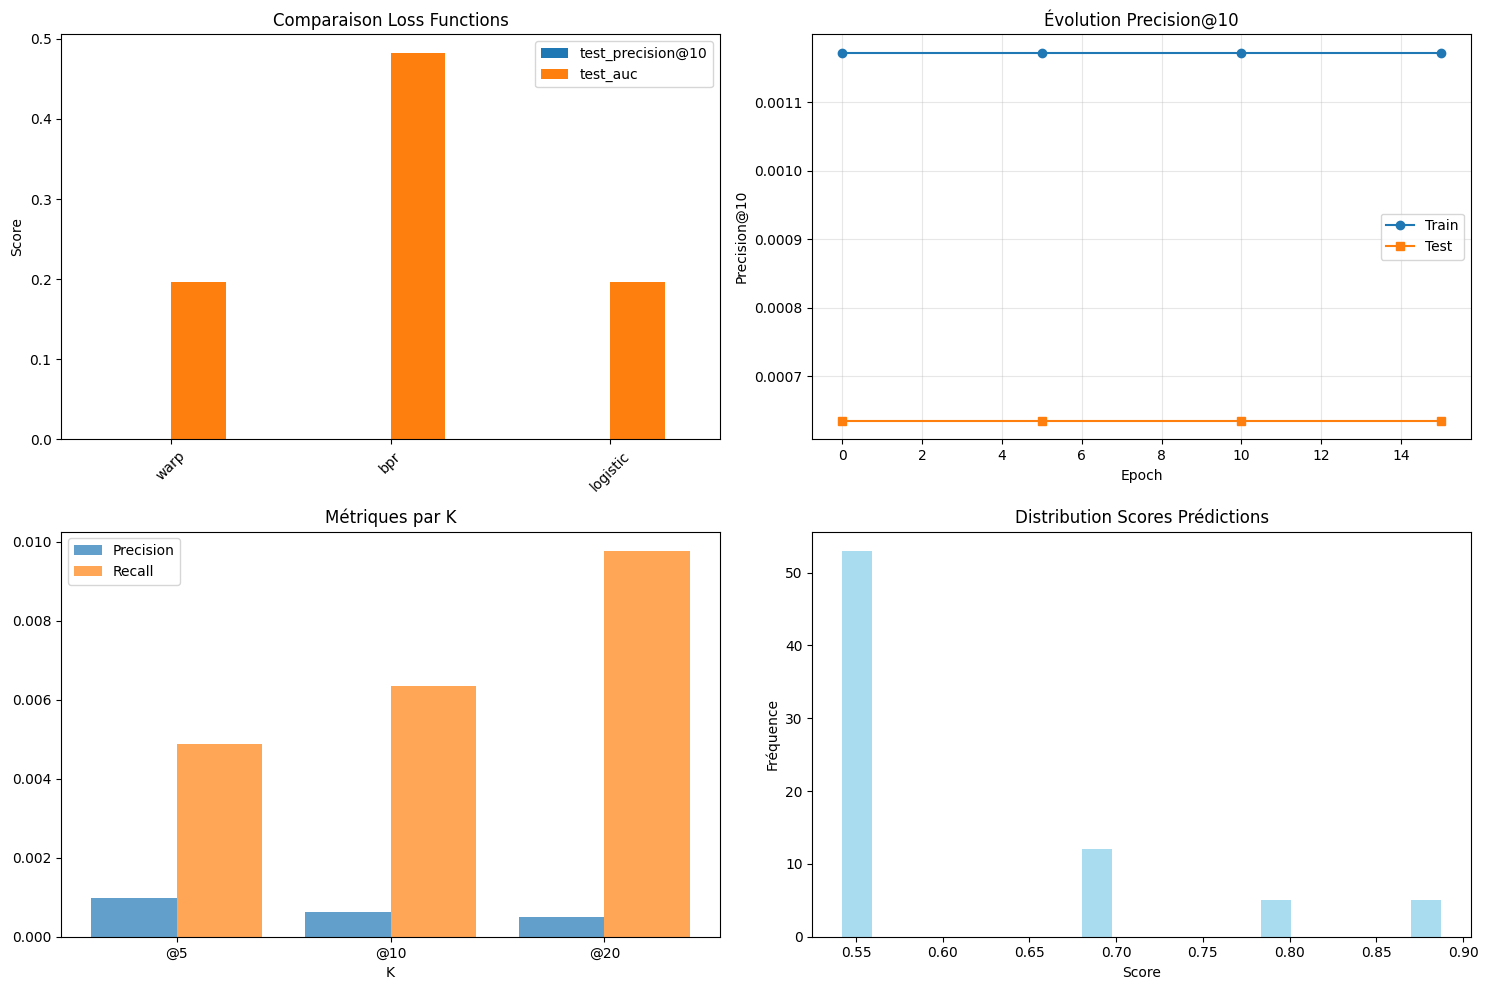

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Comparaison loss functions
comparison_df[['test_precision@10', 'test_auc']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Comparaison Loss Functions')
axes[0,0].set_ylabel('Score')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Évolution entraînement
epochs_eval = list(range(0, epochs, 5))
axes[0,1].plot(epochs_eval, train_precisions, label='Train', marker='o')
axes[0,1].plot(epochs_eval, test_precisions, label='Test', marker='s')
axes[0,1].set_title('Évolution Precision@10')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Precision@10')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Métriques par K
k_vals = [5, 10, 20]
test_precs = [final_metrics[f'test_precision@{k}'] for k in k_vals]
test_recalls = [final_metrics[f'test_recall@{k}'] for k in k_vals]

x = np.arange(len(k_vals))
axes[1,0].bar(x - 0.2, test_precs, 0.4, label='Precision', alpha=0.7)
axes[1,0].bar(x + 0.2, test_recalls, 0.4, label='Recall', alpha=0.7)
axes[1,0].set_title('Métriques par K')
axes[1,0].set_xlabel('K')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels([f'@{k}' for k in k_vals])
axes[1,0].legend()

# 4. Distribution scores prédictions
n_users_sample = min(100, train_matrix.shape[0])
user_sample = np.random.choice(train_matrix.shape[0], n_users_sample, replace=False)
scores_sample = []

for user_id in user_sample:
    user_items = train_matrix[user_id].nonzero()[1]
    if len(user_items) > 0:
        item_sample = np.random.choice(user_items, min(5, len(user_items)), replace=False)
        user_array = np.full(len(item_sample), user_id, dtype=np.int32)
        scores = optimal_model.predict(user_array, item_sample.astype(np.int32))
        scores_sample.extend(scores)


if scores_sample:
    axes[1,1].hist(scores_sample, bins=20, alpha=0.7, color='skyblue')
    axes[1,1].set_title('Distribution Scores Prédictions')
    axes[1,1].set_xlabel('Score')
    axes[1,1].set_ylabel('Fréquence')

plt.tight_layout()
plt.savefig(f"{OUTPUTS_PATH}/figures/collaborative_model_results.png", dpi=300, bbox_inches='tight')
plt.show()

## 🔍 ANALYSE DES RECOMMANDATIONS


In [11]:
print("\n" + "="*60)
print("🔍 ANALYSE QUALITATIVE")
print("="*60)


def get_recommendations(model, user_idx, train_interactions, n_recs=10):
    """Génère recommandations pour un utilisateur"""
    n_items = train_interactions.shape[1]
    known_items = train_interactions[user_idx].nonzero()[1]

    # Créer arrays de même taille
    user_array = np.full(n_items, user_idx, dtype=np.int32)
    item_array = np.arange(n_items, dtype=np.int32)
    scores = model.predict(user_array, item_array)

    # Masquer items déjà vus
    scores[known_items] = -np.inf

    # Top N
    top_items = np.argsort(-scores)[:n_recs]
    return top_items, scores[top_items]


# Test sur utilisateurs actifs
active_users = np.array(train_matrix.sum(axis=1)).flatten()
top_active_users = np.argsort(-active_users)[:5]

print("🎯 EXEMPLES DE RECOMMANDATIONS:")
for i, user_idx in enumerate(top_active_users):
    n_interactions = active_users[user_idx]
    recs, scores = get_recommendations(optimal_model, user_idx, train_matrix, 5)

    print(f"\nUser {user_idx} ({n_interactions} interactions):")
    for j, (item_idx, score) in enumerate(zip(recs, scores)):
        item_id = item_mapper.idx_to_id[item_idx]
        print(f"  {j+1}. Item {item_id}: {score:.3f}")


🔍 ANALYSE QUALITATIVE
🎯 EXEMPLES DE RECOMMANDATIONS:

User 8826 (3.0 interactions):
  1. Item 562245001: 1.707
  2. Item 706016001: 1.664
  3. Item 610776002: 1.568
  4. Item 158340001: 1.517
  5. Item 706016002: 1.516

User 6775 (3.0 interactions):
  1. Item 562245001: 1.698
  2. Item 706016001: 1.656
  3. Item 610776002: 1.560
  4. Item 372860002: 1.508
  5. Item 156231001: 1.508

User 2122 (3.0 interactions):
  1. Item 562245001: 1.703
  2. Item 706016001: 1.659
  3. Item 610776002: 1.563
  4. Item 156231001: 1.512
  5. Item 706016002: 1.512

User 9400 (2.0 interactions):
  1. Item 562245001: 1.581
  2. Item 706016001: 1.536
  3. Item 610776002: 1.440
  4. Item 706016002: 1.389
  5. Item 158340001: 1.389

User 9190 (2.0 interactions):
  1. Item 562245001: 1.591
  2. Item 706016001: 1.548
  3. Item 610776002: 1.453
  4. Item 158340001: 1.400
  5. Item 706016002: 1.400


## 💾 SAUVEGARDE MODÈLE


In [12]:
print("\n💾 Sauvegarde du modèle...")

model_results = {
    'model': optimal_model,
    'metrics': final_metrics,
    'loss_comparison': comparison_df,
    'best_loss': best_loss,
    'training_curves': {
        'epochs': epochs_eval,
        'train_precision': train_precisions,
        'test_precision': test_precisions
    },
    'model_config': {
        'loss': best_loss,
        'no_components': 50,
        'learning_rate': 0.05,
        'epochs': epochs
    },
    'metadata': {
        'train_shape': train_matrix.shape,
        'test_shape': test_matrix.shape,
        'creation_date': time.strftime('%Y-%m-%d %H:%M:%S')
    }
}

with open(f"{OUTPUTS_PATH}/collaborative_model_results.pkl", "wb") as f:
    pickle.dump(model_results, f)

print(f"✅ Modèle sauvegardé: {OUTPUTS_PATH}/collaborative_model_results.pkl")


💾 Sauvegarde du modèle...
✅ Modèle sauvegardé: /content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys/outputs/collaborative_model_results.pkl


# 🎯 RÉSUMÉ ET PROCHAINES ÉTAPES

In [13]:
print("\n" + "="*70)
print("🎯 MODÈLE COLLABORATIF TERMINÉ")
print("="*70)

print(f"\n🏆 PERFORMANCES:")
print(f"   • Loss function: {best_loss.upper()}")
print(f"   • Test Precision@10: {final_metrics['test_precision@10']:.4f}")
print(f"   • Test AUC: {final_metrics['test_auc']:.4f}")
print(f"   • Test Recall@10: {final_metrics['test_recall@10']:.4f}")

print(f"\n🚀 PROCHAINES ÉTAPES:")
print(f"   1. Optimisation hyperparamètres (Grid Search)")
print(f"   2. Évaluation plus poussée")
print(f"   3. Modèle hybride avec features articles")

print("\n✅ Baseline collaborative établie!")
print("="*70)


🎯 MODÈLE COLLABORATIF TERMINÉ

🏆 PERFORMANCES:
   • Loss function: LOGISTIC
   • Test Precision@10: 0.0006
   • Test AUC: 0.2040
   • Test Recall@10: 0.0064

🚀 PROCHAINES ÉTAPES:
   1. Optimisation hyperparamètres (Grid Search)
   2. Évaluation plus poussée
   3. Modèle hybride avec features articles

✅ Baseline collaborative établie!
